In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from ipywidgets import interact

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.ops import nms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 시작 파라미터 설정

In [2]:
data_dir = '/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/'
train_data_dir = os.path.join(data_dir, 'train/')
val_data_dir = os.path.join(data_dir, 'val/')

csv_data = pd.read_csv(data_dir + 'df.csv')
csv_data = csv_data.drop(columns=['Source', 'Confidence','IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside','XClick1X','XClick2X','XClick3X','XClick4X','XClick1Y','XClick2Y','XClick3Y','XClick4Y'])
csv_data = csv_data[['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax']]
train_data_list = os.listdir(train_data_dir)
val_data_list = os.listdir(val_data_dir)

Class_Name_To_Int = {'Bus':0, 'Truck':1}
Int_To_Class_Name = {0:'Bus', 1:'Truck'}
NUM_CLASSES = 2
VERBOSE_FREQ = 200

# 커스텀데이터셋 
## 설정 아래 loss공식때문에 X,Y,W,H로 만들어야한다.

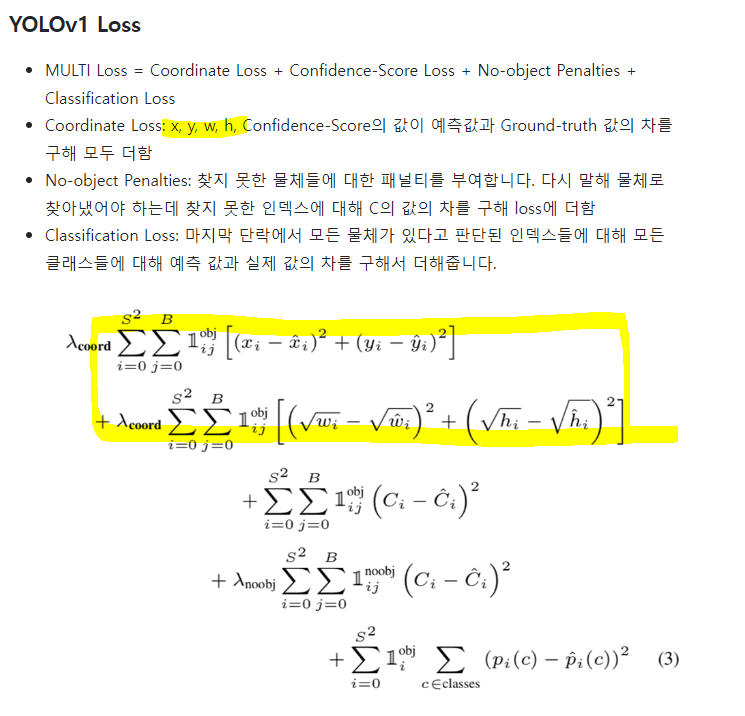

In [3]:
class car_data_set():
    def __init__(self, data_dir, phase, csv_data, transformer = None):
        self.csv_data = csv_data
        self.phase_data_dir = (data_dir + phase + '/')
        self.data_list = os.listdir(self.phase_data_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.data_list)
    
    def get_label_def(self, image_name):
        label = self.csv_data.loc[(self.csv_data['ImageID'] == image_name.split(".")[0])]
        target_name = [Class_Name_To_Int[i] for i in label['LabelName'].values]
        bounding_box = label.drop(columns = ['ImageID', 'LabelName']).values
        bounding_box[:, 2:4] -= bounding_box[:, 0:2]
        bounding_box[:, 0:2] += (bounding_box[:, 2:4] / 2)

        return target_name, bounding_box
    
    def get_image_def(self, image_name):
        image = cv2.imread(self.phase_data_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image
    

    def __getitem__(self, index):
        image_name = self.data_list[index]
        
        image = self.get_image_def(image_name)
        target_name, bboxes = self.get_label_def(image_name)

        if self.transformer:
            transformed_data = self.transformer(image=image, bboxes=bboxes, class_ids=target_name)
            image = transformed_data['image']
            bboxes = transformed_data['bboxes']
            class_ids = np.array(transformed_data['class_ids'])
        
        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, image_name

In [4]:
transformer = A.Compose([
    A.Resize(height=448,width=448),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],
    bbox_params = A.BboxParams(format='yolo', label_fields=['class_ids']),
)

In [5]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(image_list, dim=0), target_list, filename_list

In [12]:
def build_dataloader():
    
    
    dataloaders = {}
    train_data_set = car_data_set(data_dir=data_dir, phase='train', csv_data=csv_data, transformer=transformer)
    val_data_set = car_data_set(data_dir=data_dir, phase='val', csv_data=csv_data, transformer=transformer)

    dataloaders['train'] = DataLoader(train_data_set,batch_size = 10 ,shuffle=True, collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(val_data_set,batch_size = 10 ,shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [14]:
# dataloaders = build_dataloader()

# for index, batch in enumerate(dataloaders['train']):
#     images = batch[0]
#     targets = batch[1]
#     filenames = batch[2]
#     print(images.shape)
#     print(targets)
#     if index==0:
#         break

# 이미지 데이터 확인 (transformer사용 X)

# 이미지 데이터 확인 (transformer사용 O)

# 모델

In [ ]:
class YOLOv1_RESNET(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        num_classes = num_classes
        num_boxes = 2
        grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [m for m in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])

        self.head = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_boxes + num_classes, kernel_size=1, padding=0, bias=False),
            nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size))
        )
    
    def forward(self, x):
        out = self.backbone(x)
        out = self.head(out)
        return out

# yolo loss function구현

In [15]:
num_classes = 2
grid_size = 7
device = 'cpu'

#하나의 타겟값을 만들어줌
def build_target_grid(target):
    target_grid = torch.zeros((1+4+num_classes, grid_size, grid_size), device=device)

    for gt in target:
        xc, yc, w, h, cls_id = gt
        x_grid_center = (xc % (1/grid_size)) #그리드로 나누고 그 안에 위치
        y_grid_center = (yc % (1/grid_size))
        cls_id = int(cls_id)

        x_grid_number = int(xc * grid_size) #몇번째 그리드 인지
        y_grid_number = int(yc * grid_size)
        target_grid[0, x_grid_number,y_grid_number] = 1
        target_grid[1:5, x_grid_number, y_grid_number] = torch.Tensor([x_grid_center, y_grid_center, w, h])
        target_grid[5+cls_id, x_grid_number, y_grid_number] = 1
    
    return target_grid

#만약에 배치형태라면 배치만큼 배치 각각 만들어줘야하니깐
def build_batch_target_grid(targets):
    target_grid_batch = torch.stack([build_target_grid(target) for target in targets], dim=0)
    return target_grid_batch

        

In [23]:
dataloaders = build_dataloader()

for index, batch in enumerate(dataloaders['train']):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    print(f"배치 하나에 들어있는 이미지 모양    : {images.shape}")
    # print(targets)
    if index==0:
        break
groundtruths = build_batch_target_grid(targets)
print(f"배치 하나에 타겟값 행렬로 만든 모양 : {groundtruths.shape}")

배치 하나에 들어있는 이미지 모양    : torch.Size([10, 3, 448, 448])
배치 하나에 타겟값 행렬로 만든 모양 : torch.Size([10, 7, 7, 7])


In [ ]:
def generate_xy_normed_grid(grid_size):
    

In [ ]:
def xywh_to_xyxy(bboxes):
    num_batch, _, grid_size, grid_size = bboxes.shape
    xy_normed_grid = generate_xy_normed_gird(grid_size=grid_size)


In [ ]:
def get_iou(cbox1, cbox2):
    box1 = xywh_to_xyxy(cbox1)
    box2 = xywh_to_xyxy(cbox2)